# Lung Segmentation
## WaterShed Transform
워터쉐드란 segmentation 알고리즘 중 하나이다. 영상의 픽셀 값을 2차원 지형으로 생각하고 위 아래 방향에서 물을 채우는 방식임.

크게 영상을 segmentation하는 방법은 2가지로 나뉜다. 
1. Edge-based(윤곽선 기반 영상 분할 방법)
2. Region-based(영역 기반 영상 분할 방법)

첫번째 방법 같은 경우는 경계선을 기반으로 의미있는 영역들을 추출하는 방법이다. 경계선을 위주로 Detect 하다 보니 잡음에 민감하고, 끊어진 형태, 즉 폐곡선 형태의 경계선을 얻기 어려운 단점이 있다. 두번째 방법 같은 경우는 각 픽셀 간 명암도의 유사성에 기반한 방법으로 잡음이 많은 환경에서 물체를 분할하는데 적합하다. 그러나 번짐현상이 있는 영상에서 쓰기엔 적절하지 않다.

워터쉐드는 영역기반 알고리즘이다. 
높은 값을 갖는 픽셀들을 봉우리(Peak) 또는 워터쉐드 라인(WaterShed Line)이라고 하고, 
낮은 값을 갖는 픽셀들을 골짜기(Valley) 또는 국부 최소값(Regionalminimum)이라고 표현한다. 영상 내에서 픽셀들의 집합을 하나의 지형으로 간주하고 높낮이를 분석하는 방법이다. 


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pydicom
import os
import scipy.ndimage as ndimage
from skimage import measure, morphology, segmentation
import matplotlib.pyplot as plt

import time

In [7]:
INPUT_FOLDER = '/kaggle/input/osic-pulmonary-fibrosis-progression/train/'

patients = os.listdir(INPUT_FOLDER)
patients.sort()

print('Some examples of patient IDs:')
print(",\n". join(patients[:5]))

Some examples of patient IDs:
ID00007637202177411956430,
ID00009637202177434476278,
ID00010637202177584971671,
ID00011637202177653955184,
ID00012637202177665765362


In [4]:
def load_scan(path):
    
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try: # 슬라이스 간 두께를 계산.  
        # 대부분의 DICOM 파일에는 ImagePositionPatient 속성을 통해 슬라이스의 위치가 저장되어 있음.
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        # 그러나 이 속성이 없는 경우를 대비하여 SliceLocation 속성을 사용하여 두 슬라이스 사이의 거리를 계산.
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

## Hounsfield Units
CT 스캔의 측정 단위는 방사선 밀도를 측정하는 HU(Hounsfield Unit)

하운스필드 유닛(HU)은 컴퓨터 단층 촬영(CT) 스캔에서 CT 숫자를 표준화되고 편리한 형태로 표현하기 위해 보편적으로 사용되는 무차원 단위. 하운스필드 유닛은 측정된 감쇠 계수의 선형 변환으로부터 얻어진다.

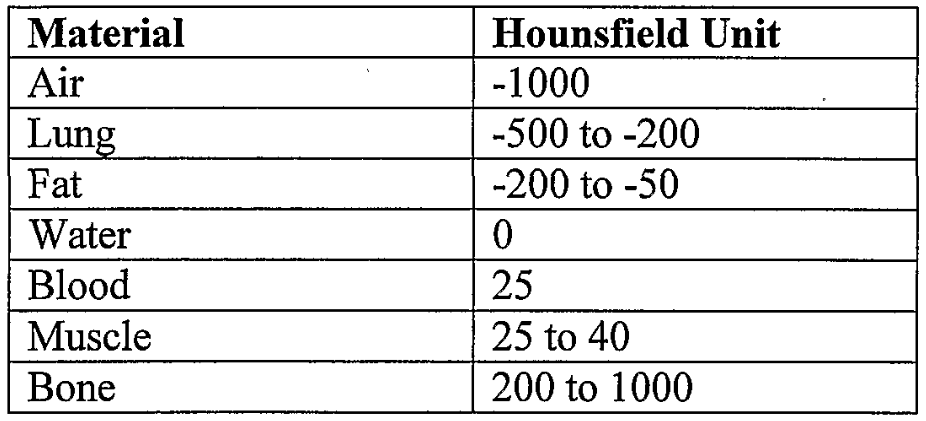
이 단위를 통해 CT로 촬영한 영상에서 어떤 물체가 있는지 찾을 수 있다.

HU=m∗P+b
 
where,

m = RescaleSlope attribute of the DICOM image,

b = RescaleIntercept attribute of the DICOM image,

P = Pixel Array

In [5]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    
    image[image == -2000] = 0 # 특정 값(-2000)이 있는 픽셀은 0으로 설정하여 이미지를 보정. 이 값은 주로 스캔 중에 발생하는 빈 영역을 나타냄
    
    # HU = m*P + b
    intercept = scans[0].RescaleIntercept # b
    slope = scans[0].RescaleSlope # m
    
    if slope != 1: # 스캔의 기울기가 1이 아닌 경우(즉, 픽셀 값에 기울기가 적용되어 있는 경우) 아래의 변환을 수행
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype = np.int16)

In [8]:
test_patient_scans = load_scan(INPUT_FOLDER + patients[24])
test_patient_images = get_pixels_hu(test_patient_scans)

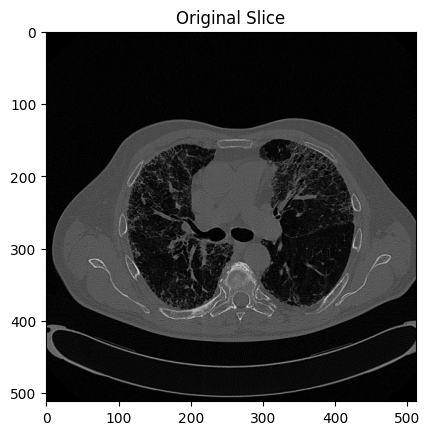

In [9]:
plt.imshow(test_patient_images[12], cmap='gray')
plt.title('Original Slice')
plt.show()

## Marker Generation

In [23]:
def generate_markers(image):
    marker_internal = image < -400 # 주어진 이미지에서 임계값(-400)보다 작은 값들을 내부 마커로 설정
    marker_internal = segmentation.clear_border(marker_internal) # 내부 마커에서 가장자리를 지움. 이는 외부 영역과의 혼동을 방지하기 위함
    marker_internal_labels = measure.label(marker_internal) # 내부 마커를 기반으로 각각의 연결된 영역에 라벨을 부여
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)] # 내부 마커 영역의 넓이를 계산 
    areas.sort() # 넓이 정렬
    
    if len(areas) > 2: # 내부 마커 영역이 2개 이상일 경우에만 실행 
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]: # 현재 영역의 넓이가 두 번째로 큰 영역보다 작은 경우 
                for coordinates in region.coords: # 해당 영역의 모든 좌표에 대해 반복                 
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0 # 해당 좌표를 내부 마커에서 제외
    
    marker_internal = marker_internal_labels > 0 # 내부 마커를 갱신
    
    external_a = ndimage.binary_dilation(marker_internal, iterations=10) # 내부 마커를 팽창시킵니다. 여기서는 10번의 반복을 수행
    external_b = ndimage.binary_dilation(marker_internal, iterations=55) # 내부 마커를 더 강하게 팽창시킵니다. 55번의 반복을 수행
    marker_external = external_b ^ external_a # 내부 마커에서 강한 팽창을 한 것과 약한 팽창을 한 것의 차를 계산하여 외부 마커를 정의
    
    marker_watershed = np.zeros((512, 512), dtype=np.int16) # 워터셰드 마커를 생성 
    marker_watershed += marker_internal * 255 # 내부 마커를 워터셰드 마커에 추가. 255로 표시
    marker_watershed += marker_external * 128 # 외부 마커를 워터셰드 마커에 추가. 128로 표시
    
    return marker_internal, marker_external, marker_watershed # 내부, 외부, 그리고 워터셰드 마커를 반환

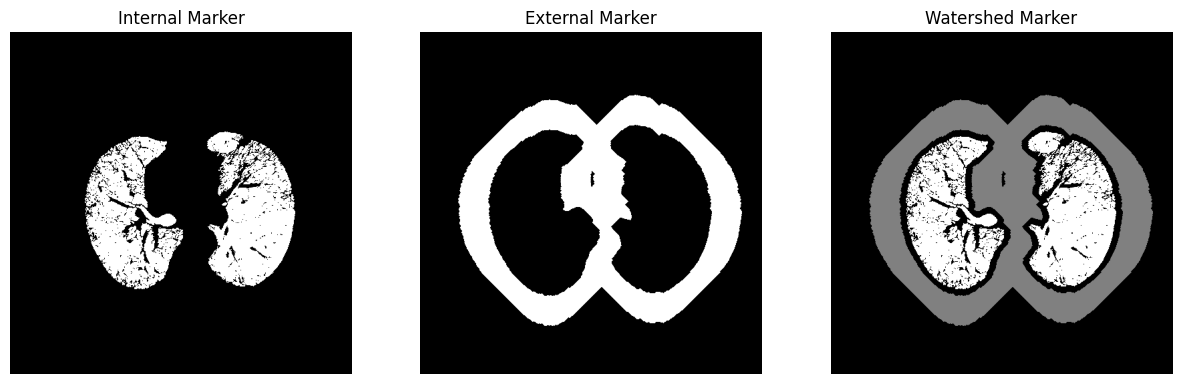

In [24]:
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_images[12])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))

ax1.imshow(test_patient_internal, cmap='gray')
ax1.set_title("Internal Marker")
ax1.axis('off')

ax2.imshow(test_patient_external, cmap='gray')
ax2.set_title("External Marker")
ax2.axis('off')

ax3.imshow(test_patient_watershed, cmap='gray')
ax3.set_title("Watershed Marker")
ax3.axis('off')

plt.show()

## Sobel Gradient and Edge Outlining
Sobel 연산자는 이미지에서 2차원 공간 기울기를 측정하여 가장자리에 해당하는 공간 주파수가 높은 영역을 강조

3×3 컨볼루션 커널의 쌍으로 이루어져 있다.
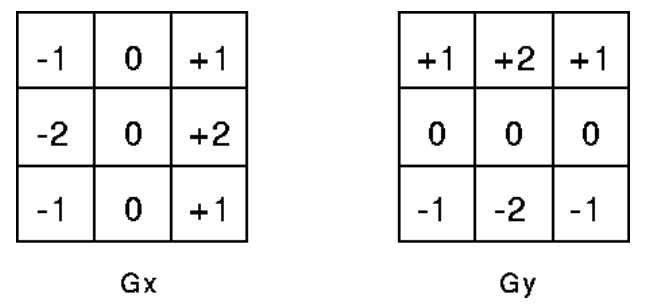 

기울기의 크기는 다음과 같다: G = sqrt(Gx^2 + Gy^2)

Sobel 기울기는 scipy.ndimage를 통해 계산할 수 있음.

In [25]:
computation_times = []
iteration_titles = []

In [55]:
from skimage.segmentation import watershed

def seperate_lungs(image, iterations = 1):
    start = time.time()
    
    marker_internal, marker_externak, marker_watershed = generate_markers(image)
    
    # Sobel 필터를 사용하여 이미지의 x 및 y 방향의 기울기를 계산
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy) # Sobel 필터링된 이미지의 x 및 y 방향 기울기의 절대값을 계산하여 기울기 이미지를 생성
    sobel_gradient *= 255.0 / np.max(sobel_gradient) # 기울기 이미지의 값을 정규화
    
    watershed_val = watershed(sobel_gradient, marker_watershed) # 모폴로지 워터셰드를 사용하여 기울기 이미지와 워터셰드 마커를 이용하여 이미지를 분할
    
    outline = ndimage.morphological_gradient(watershed_val, size = (3, 3)) # 워터셰드 결과에서 outline 추출
    outline = outline.astype(bool) # ouline을 bool로 변환 
    
    # 블랙햇 연산에 사용할 커널 정의 
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, iterations) # 블랙햇 연산에 사용할 커널을 반복해 구조를 만듬 
    
    outline += ndimage.black_tophat(outline, structure=blackhat_struct) # ouuline image에 블랙햇 연산을 적용해 보전
    
    lungfilter = np.bitwise_or(marker_internal, outline) # 내부 마커와 ouline을 합침
    # binary closing 연산을 수행하여 노이즈를 제거하고 폐를 더욱 정확하게 분할
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    # 이진 마스크를 사용하여 이미지에서 폐를 추출하고, 추출된 폐를 제외한 영역을 -2000으로 채움
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    # Append computation time
    end = time.time()
    computation_times.append(end - start) 
    iteration_titles.append("{num} iterations".format(num = iterations))
    
    
    return segmented, lungfilter, outline, watershed_val, sobel_gradient

시간에 따른 비교 

In [56]:
for itrs in range(1, 9):
    test_segmented, test_lungfilter, test_outline, test_watershed, test_sobel_gradient = seperate_lungs(test_patient_images[12], itrs)

/tmp/ipykernel_33/3770983618.py:34: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)


In [57]:
itr_dict = {'Iterations' : iteration_titles, 'Computation Times (in seconds)': computation_times}

colors = ['#30336b',] * 8
colors[0] = '#eb4d4b'

import plotly.express as px
import plotly.graph_objects as go


fig = go.Figure(data=[go.Bar(
    x=itr_dict['Iterations'],
    y=itr_dict['Computation Times (in seconds)'],
    marker_color = colors
)])
fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')


fig.update_layout(
    title = 'Iterations vs Computation Times',
    yaxis=dict(
        title='Computation Times (in seconds)',
        titlefont_size=16,
        tickfont_size=14,
    ),
    autosize=False,
    width=800,
    height=800)

fig.show()

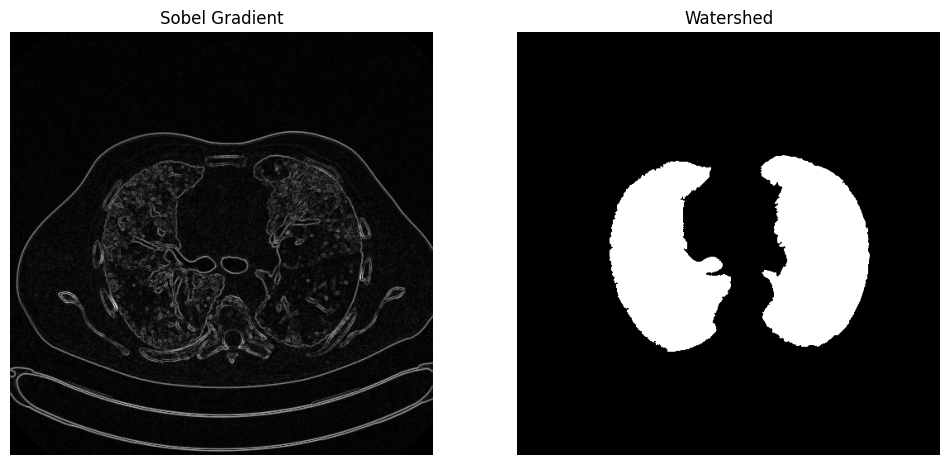

In [58]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12, 12))

ax1.imshow(test_sobel_gradient, cmap='gray')
ax1.set_title("Sobel Gradient")
ax1.axis('off')

ax2.imshow(test_watershed, cmap='gray')
ax2.set_title("Watershed")
ax2.axis('off')

plt.show()

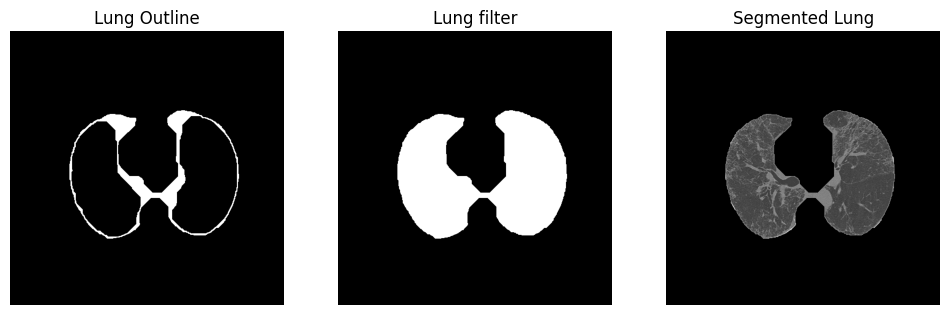

In [59]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (12, 12))

ax1.imshow(test_outline, cmap='gray')
ax1.set_title("Lung Outline")
ax1.axis('off')

ax2.imshow(test_lungfilter, cmap='gray')
ax2.set_title("Lung filter")
ax2.axis('off')

ax3.imshow(test_segmented, cmap='gray')
ax3.set_title("Segmented Lung")
ax3.axis('off')

plt.show()

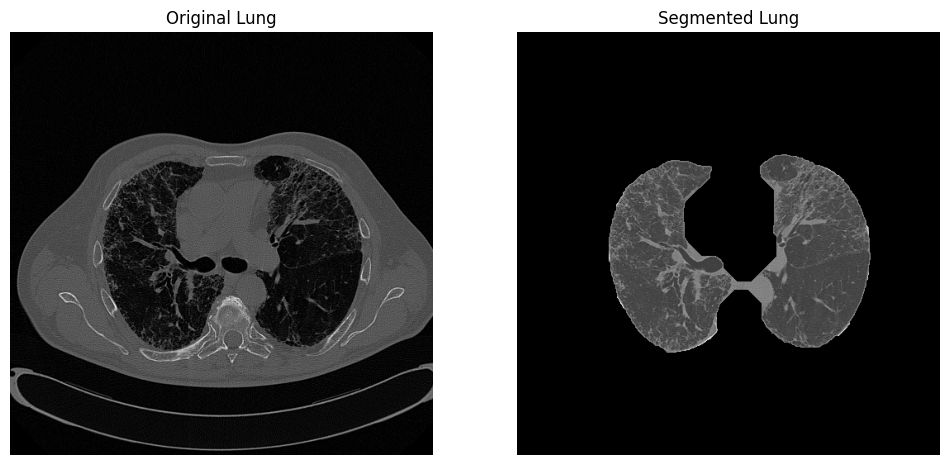

In [60]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12, 12))

ax1.imshow(test_patient_images[12], cmap='gray')
ax1.set_title("Original Lung")
ax1.axis('off')

ax2.imshow(test_segmented, cmap='gray')
ax2.set_title("Segmented Lung")
ax2.axis('off')

plt.show()